# Test Unfold 3
<hr style="border-top-width: 4px; border-top-color: #34609b;">
Simple Test program for the class TUnfoldDensity

1-dimensional unfolding with background subtraction

 the goal is to unfold the underlying "true" distribution of a variable Pt

 the reconstructed Pt is measured in 24 bins from 4 to 28
 the generator-level Pt is unfolded into 10 bins from 6 to 26
   plus underflow bin from 0 to 6
   plus overflow bin above 26
 there are two background sources
      bgr1 and bgr2
 the signal has a finite trigger efficiency at a threshold of 8 GeV

 one type of systematic error is studied, where the signal parameters are
 changed

 Finally, the unfolding is compared to a "bin-by-bin" correction method

 History:
 - Version 17.0, changeto use the class TUnfoldDensity
 - Version 16.1, parallel to changes in TUnfold
 - Version 16.0, parallel to changes in TUnfold
 - Version 15, simple example including background subtraction




**Author:** Stefan Schmitt, DESY  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-mirror/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer (Beta)</a> from the macro found in the ROOT repository  on Thursday, January 19, 2017 at 04:36 PM.</small></i>

In [1]:
%%cpp -d
#include <TMath.h>
#include <TCanvas.h>
#include <TRandom3.h>
#include <TFitter.h>
#include <TF1.h>
#include <TStyle.h>
#include <TVector.h>
#include <TGraph.h>

#include "TUnfoldDensity.h"

using namespace std;


TRandom *rnd=0;

Int main(int argc, char *argv[])

 A helper function is created: 

In [2]:
%%cpp -d
Double_t GenerateEvent(const Double_t *parm,
                       const Double_t *triggerParm,
                       Double_t *intLumi,
                       Bool_t *triggerFlag,
                       Double_t *ptGen,Int_t *iType)
{
   // generate an event
   // input:
   //      parameters for the event generator
   // return value:
   //      reconstructed Pt
   // output to pointers:
   //      integrated luminosity
   //      several variables only accessible on generator level
   //
   // the parm array defines the physical parameters
   //  parm[0]: background source 1 fraction
   //  parm[1]: background source 2 fraction
   //  parm[2]: lower limit of generated Pt distribution
   //  parm[3]: upper limit of generated Pt distribution
   //  parm[4]: exponent for Pt distribution signal
   //  parm[5]: exponent for Pt distribution background 1
   //  parm[6]: exponent for Pt distribution background 2
   //  parm[7]: resolution parameter a goes with sqrt(Pt)
   //  parm[8]: resolution parameter b goes with Pt
   //  triggerParm[0]: trigger threshold turn-on position
   //  triggerParm[1]: trigger threshold turn-on width
   //  triggerParm[2]: trigger efficiency for high pt
   //
   // intLumi is advanced bu 1 for each *generated* event
   // for data, several events may be generated, until one passes the trigger
   //
   // some generator-level quantities are also returned:
   //   triggerFlag: whether the event passed the trigger threshold
   //   ptGen: the generated pt
   //   iType: which type of process was simulated
   //
   // the "triggerFlag" also has another meaning:
   //   if(triggerFlag==0)   only triggered events are returned
   //
   // Usage to generate data events
   //      ptObs=GenerateEvent(parm,triggerParm,0,0,0)
   //
   // Usage to generate MC events
   //      ptGen=GenerateEvent(parm,triggerParm,&triggerFlag,&ptGen,&iType);
   //
   Double_t ptObs;
   Bool_t isTriggered=kFALSE;
   do {
      Int_t itype;
      Double_t ptgen;
      Double_t f=rnd->Rndm();
      // decide whether this is background or signal
      itype=0;
      if(f<parm[0]) itype=1;
      else if(f<parm[0]+parm[1]) itype=2;
      // generate Pt according to distribution  pow(ptgen,a)
      // get exponent
      Double_t a=parm[4+itype];
      Double_t a1=a+1.0;
      Double_t t=rnd->Rndm();
      if(a1 == 0.0) {
         Double_t x0=TMath::Log(parm[2]);
         ptgen=TMath::Exp(t*(TMath::Log(parm[3])-x0)+x0);
      } else {
         Double_t x0=pow(parm[2],a1);
         ptgen=pow(t*(pow(parm[3],a1)-x0)+x0,1./a1);
      }
      if(iType) *iType=itype;
      if(ptGen) *ptGen=ptgen;

      // smearing in Pt with large asymmetric tail
      Double_t sigma=
         TMath::Sqrt(parm[7]*parm[7]*ptgen+parm[8]*parm[8]*ptgen*ptgen);
      ptObs=rnd->BreitWigner(ptgen,sigma);

      // decide whether event was triggered
      Double_t triggerProb =
         triggerParm[2]/(1.+TMath::Exp((triggerParm[0]-ptObs)/triggerParm[1]));
      isTriggered= rnd->Rndm()<triggerProb;
      (*intLumi) ++;
   } while((!triggerFlag) && (!isTriggered));
   // return trigger decision
   if(triggerFlag) *triggerFlag=isTriggered;
   return ptObs;
}

In [3]:
  // switch on histogram errors
  TH1::SetDefaultSumw2();

  // show fit result
  gStyle->SetOptFit(1111);

  // random generator
  rnd=new TRandom3();

  // data and MC luminosities
  Double_t const lumiData= 30000;
  Double_t const lumiMC  =1000000;

  //========================
  // Step 1: define binning, book histograms

  // reconstructed pt (fine binning)
  Int_t const nDet=24;
  Double_t const xminDet=4.0;
  Double_t const xmaxDet=28.0;

  // generated pt (coarse binning)
  Int_t const nGen=10;
  Double_t const xminGen= 6.0;
  Double_t const xmaxGen=26.0;

  //==================================================================
  // book histograms
  //  (1) unfolding input: binning scheme is fine for detector,coarse for gen
  //   histUnfoldInput : reconstructed data, binning for unfolding
  //   histUnfoldMatrix : generated vs reconstructed distribution
  //   histUnfoldBgr1 : background source1, as predicted by MC
  //   histUnfoldBgr2 : background source2, as predicted by MC
  //      for systematic studies
  //   histUnfoldMatrixSys : generated vs reconstructed with different signal
  //
  //  (2) histograms required for bin-by-bin method
  //   histDetDATAbbb : reconstructed data for bin-by-bin
  //   histDetMCbbb : reconstructed MC for bin-by-bin
  //   histDetMCBgr1bbb : reconstructed MC bgr1 for bin-by-bin
  //   histDetMCBgr2bbb : reconstructed MC bgr2 for bin-by-bin
  //   histDetMCBgrPtbbb : reconstructed MC bgr from low/high pt for bin-by-bin
  //   histGenMCbbb : generated MC truth
  //     for systematic studies
  //   histDetMCSysbbb : reconstructed with changed trigger
  //   histGenMCSysbbb : generated MC truth
  //
  //  (3) monitoring and control
  //   histGenData : data truth for bias tests
  //   histDetMC : MC prediction

  // (1) create histograms required for unfolding
  TH1D *histUnfoldInput=
  new TH1D("unfolding input rec",";ptrec",nDet,xminDet,xmaxDet);
  TH2D *histUnfoldMatrix=
  new TH2D("unfolding matrix",";ptgen;ptrec",
           nGen,xminGen,xmaxGen,nDet,xminDet,xmaxDet);
  TH1D *histUnfoldBgr1=
  new TH1D("unfolding bgr1 rec",";ptrec",nDet,xminDet,xmaxDet);
  TH1D *histUnfoldBgr2=
  new TH1D("unfolding bgr2 rec",";ptrec",nDet,xminDet,xmaxDet);
  TH2D *histUnfoldMatrixSys=
  new TH2D("unfolding matrix sys",";ptgen;ptrec",
           nGen,xminGen,xmaxGen,nDet,xminDet,xmaxDet);

  // (2) histograms required for bin-by-bin
  TH1D *histBbbInput=
  new TH1D("bbb input rec",";ptrec",nGen,xminGen,xmaxGen);
  TH1D *histBbbSignalRec=
  new TH1D("bbb signal rec",";ptrec",nGen,xminGen,xmaxGen);
  TH1D *histBbbBgr1=
  new TH1D("bbb bgr1 rec",";ptrec",nGen,xminGen,xmaxGen);
  TH1D *histBbbBgr2=
  new TH1D("bbb bgr2 rec",";ptrec",nGen,xminGen,xmaxGen);
  TH1D *histBbbBgrPt=
  new TH1D("bbb bgrPt rec",";ptrec",nGen,xminGen,xmaxGen);
  TH1D *histBbbSignalGen=
  new TH1D("bbb signal gen",";ptgen",nGen,xminGen,xmaxGen);
  TH1D *histBbbSignalRecSys=
  new TH1D("bbb signal sys rec",";ptrec",nGen,xminGen,xmaxGen);
  TH1D *histBbbBgrPtSys=
  new TH1D("bbb bgrPt sys rec",";ptrec",nGen,xminGen,xmaxGen);
  TH1D *histBbbSignalGenSys=
  new TH1D("bbb signal sys gen",";ptgen",nGen,xminGen,xmaxGen);

  // (3) control histograms
  TH1D *histDataTruth=
  new TH1D("DATA truth gen",";ptgen",nGen,xminGen,xmaxGen);
  TH1D *histDetMC=
  new TH1D("MC prediction rec",";ptrec",nDet,xminDet,xmaxDet);
  // ==============================================================
  // Step 2: generate data distributions
  //
  // data parameters: in real life these are unknown
  static Double_t parm_DATA[]={
  0.05, // fraction of background 1 (on generator level)
  0.05, // fraction of background 2 (on generator level)
  3.5, // lower Pt cut (generator level)
  100.,// upper Pt cut (generator level)
  -3.0,// signal exponent
  0.1, // background 1 exponent
  -0.5, // background 2 exponent
  0.2, // energy resolution a term
  0.01, // energy resolution b term
  };
  static Double_t triggerParm_DATA[]={8.0, // threshold is 8 GeV
                            4.0, // width is 4 GeV
                            0.95 // high Pt efficiency os 95%
  };

  Double_t intLumi=0.0;
  while(intLumi<lumiData) {
  Int_t iTypeGen;
  Bool_t isTriggered;
  Double_t ptGen;
  Double_t ptObs=GenerateEvent(parm_DATA,triggerParm_DATA,&intLumi,
                               &isTriggered,&ptGen,&iTypeGen);
  if(isTriggered) {
     // (1) histogram for unfolding
     histUnfoldInput->Fill(ptObs);

     // (2) histogram for bin-by-bin
     histBbbInput->Fill(ptObs);
  }
  // (3) monitoring
  if(iTypeGen==0) histDataTruth->Fill(ptGen);
  }

  // ==============================================================
  // Step 3: generate default MC distributions
  //
  // MC parameters
  // default settings
  static Double_t parm_MC[]={
  0.05, // fraction of background 1 (on generator level)
  0.05, // fraction of background 2 (on generator level)
  3.5, // lower Pt cut (generator level)
  100.,// upper Pt cut (generator level)
  -4.0,// signal exponent !!! steeper than in data
       //                     to illustrate bin-by-bin bias
  0.1, // background 1 exponent
  -0.5, // background 2 exponent
  0.2, // energy resolution a term
  0.01, // energy resolution b term
  };
  static Double_t triggerParm_MC[]={8.0, // threshold is 8 GeV
                          4.0, // width is 4 GeV
                          0.95 // high Pt efficiency is 95%
  };

  // weighting factor to accomodate for the different luminosity in data and MC
  Double_t lumiWeight = lumiData/lumiMC;
  intLumi=0.0;
  while(intLumi<lumiMC) {
  Int_t iTypeGen;
  Bool_t isTriggered;
  Double_t ptGen;
  Double_t ptObs=GenerateEvent(parm_MC,triggerParm_MC,&intLumi,&isTriggered,
                               &ptGen,&iTypeGen);
  if(!isTriggered) ptObs=0.0;

  // (1) distribution required for unfolding

  if(iTypeGen==0) {
     histUnfoldMatrix->Fill(ptGen,ptObs,lumiWeight);
  } else if(iTypeGen==1) {
     histUnfoldBgr1->Fill(ptObs,lumiWeight);
  } else if(iTypeGen==2) {
     histUnfoldBgr2->Fill(ptObs,lumiWeight);
  }

  // (2) distributions for bbb
  if(iTypeGen==0) {
     if((ptGen>=xminGen)&&(ptGen<xmaxGen)) {
        histBbbSignalRec->Fill(ptObs,lumiWeight);
     } else {
        histBbbBgrPt->Fill(ptObs,lumiWeight);
     }
     histBbbSignalGen->Fill(ptGen,lumiWeight);
  } else if(iTypeGen==1) {
     histBbbBgr1->Fill(ptObs,lumiWeight);
  } else if(iTypeGen==2) {
     histBbbBgr2->Fill(ptObs,lumiWeight);
  }

  // (3) control distribution
  histDetMC ->Fill(ptObs,lumiWeight);
  }

  // ==============================================================
  // Step 4: generate MC distributions for systematic study
  // example: study dependence on initial signal shape
  //   -> BGR distributions do not change
  static Double_t parm_MC_SYS[]={
  0.05, // fraction of background: unchanged
  0.05, // fraction of background: unchanged
  3.5, // lower Pt cut (generator level)
  100.,// upper Pt cut (generator level)
  -2.0, // signal exponent changed
  0.1, // background 1 exponent
  -0.5, // background 2 exponent
  0.2, // energy resolution a term
  0.01, // energy resolution b term
  };

  intLumi=0.0;
  while(intLumi<lumiMC) {
  Int_t iTypeGen;
  Bool_t isTriggered;
  Double_t ptGen;
  Double_t ptObs=GenerateEvent(parm_MC_SYS,triggerParm_MC,&intLumi,
                               &isTriggered,&ptGen,&iTypeGen);
  if(!isTriggered) ptObs=0.0;

  // (1) for unfolding
  if(iTypeGen==0) {
     histUnfoldMatrixSys->Fill(ptGen,ptObs);
  }

  // (2) for bin-by-bin
  if(iTypeGen==0) {
     if((ptGen>=xminGen)&&(ptGen<xmaxGen)) {
        histBbbSignalRecSys->Fill(ptObs);
     } else {
        histBbbBgrPtSys->Fill(ptObs);
     }
     histBbbSignalGenSys->Fill(ptGen);
  }
  }

  // this method is new in version 16 of TUnfold
  cout<<"TUnfold version is "<<TUnfold::GetTUnfoldVersion()<<"\n";

  //========================
  // Step 5: unfolding
  //

  // here one has to decide about the regularisation scheme

  // regularize curvature
  TUnfold::ERegMode regMode =
  TUnfold::kRegModeCurvature;

 // preserve the area
  TUnfold::EConstraint constraintMode=
  TUnfold::kEConstraintArea;

  // bin content is divided by the bin width
  TUnfoldDensity::EDensityMode densityFlags=
  TUnfoldDensity::kDensityModeBinWidth;

  // set up matrix of migrations
  TUnfoldDensity unfold(histUnfoldMatrix,TUnfold::kHistMapOutputHoriz,
                     regMode,constraintMode,densityFlags);

  // define the input vector (the measured data distribution)
  unfold.SetInput(histUnfoldInput);

  // subtract background, normalized to data luminosity
  //  with 10% scale error each
  Double_t scale_bgr=1.0;
  Double_t dscale_bgr=0.1;
  unfold.SubtractBackground(histUnfoldBgr1,"background1",scale_bgr,dscale_bgr);
  unfold.SubtractBackground(histUnfoldBgr2,"background2",scale_bgr,dscale_bgr);

  // add systematic error
  unfold.AddSysError(histUnfoldMatrixSys,"signalshape_SYS",
                  TUnfold::kHistMapOutputHoriz,
                  TUnfoldSys::kSysErrModeMatrix);

  // run the unfolding
  Int_t nScan=30;
  TSpline *logTauX,*logTauY;
  TGraph *lCurve;
  // this method scans the parameter tau and finds the kink in the L curve
  // finally, the unfolding is done for the best choice of tau
  Int_t iBest=unfold.ScanLcurve(nScan,0.,0.,&lCurve,&logTauX,&logTauY);

  cout<<"chi**2="<<unfold.GetChi2A()<<"+"<<unfold.GetChi2L()
   <<" / "<<unfold.GetNdf()<<"\n";

  // save graphs with one point to visualize best choice of tau
  Double_t t[1],x[1],y[1];
  logTauX->GetKnot(iBest,t[0],x[0]);
  logTauY->GetKnot(iBest,t[0],y[0]);
  TGraph *bestLcurve=new TGraph(1,x,y);
  TGraph *bestLogTauLogChi2=new TGraph(1,t,x);


  //===========================
  // Step 6: retreive unfolding results

  // get unfolding output
  // includes the statistical and background errors
  // but not the other systematic uncertainties
  TH1 *histUnfoldOutput=unfold.GetOutput("PT(unfold,stat+bgrerr)");

  // retreive error matrix of statistical errors
  TH2 *histEmatStat=unfold.GetEmatrixInput("unfolding stat error matrix");

  // retreive full error matrix
  // This includes all systematic errors
  TH2 *histEmatTotal=unfold.GetEmatrixTotal("unfolding total error matrix");

  // create two copies of the unfolded data, one with statistical errors
  // the other with total errors
  TH1 *histUnfoldStat=new TH1D("PT(unfold,staterr)",";Pt(gen)",
                             nGen,xminGen,xmaxGen);
  TH1 *histUnfoldTotal=new TH1D("PT(unfold,totalerr)",";Pt(gen)",
                              nGen,xminGen,xmaxGen);
  for(Int_t i=0;i<nGen+2;i++) {
  Double_t c=histUnfoldOutput->GetBinContent(i);

  // histogram with unfolded data and stat errors
  histUnfoldStat->SetBinContent(i,c);
  histUnfoldStat->SetBinError
     (i,TMath::Sqrt(histEmatStat->GetBinContent(i,i)));

  // histogram with unfolded data and total errors
  histUnfoldTotal->SetBinContent(i,c);
  histUnfoldTotal->SetBinError
     (i,TMath::Sqrt(histEmatTotal->GetBinContent(i,i)));
  }

  // create histogram with correlation matrix
  TH2D *histCorr=new TH2D("Corr(total)",";Pt(gen);Pt(gen)",
                       nGen,xminGen,xmaxGen,nGen,xminGen,xmaxGen);
  for(Int_t i=0;i<nGen+2;i++) {
  Double_t ei,ej;
  ei=TMath::Sqrt(histEmatTotal->GetBinContent(i,i));
  if(ei<=0.0) continue;
  for(Int_t j=0;j<nGen+2;j++) {
     ej=TMath::Sqrt(histEmatTotal->GetBinContent(j,j));
     if(ej<=0.0) continue;
     histCorr->SetBinContent(i,j,histEmatTotal->GetBinContent(i,j)/ei/ej);
  }
  }

  // retreive bgr source 1
  TH1 *histDetNormBgr1=unfold.GetBackground("bgr1 normalized",
                                          "background1");
  TH1 *histDetNormBgrTotal=unfold.GetBackground("bgr total normalized");

  //========================
  // Step 7: plots

  TCanvas *output = new TCanvas();
  output->Divide(3,2);
  output->cd(1);
  // data, MC prediction, background
  histUnfoldInput->SetMinimum(0.0);
  histUnfoldInput->Draw("E");
  histDetMC->SetMinimum(0.0);
  histDetMC->SetLineColor(kBlue);
  histDetNormBgrTotal->SetLineColor(kRed);
  histDetNormBgr1->SetLineColor(kCyan);
  histDetMC->Draw("SAME HIST");
  histDetNormBgr1->Draw("SAME HIST");
  histDetNormBgrTotal->Draw("SAME HIST");

  output->cd(2);
  // unfolded data, data truth, MC truth
  histUnfoldTotal->SetMinimum(0.0);
  histUnfoldTotal->SetMaximum(histUnfoldTotal->GetMaximum()*1.5);
  // outer error: total error
  histUnfoldTotal->Draw("E");
  // middle error: stat+bgr
  histUnfoldOutput->Draw("SAME E1");
  // inner error: stat only
  histUnfoldStat->Draw("SAME E1");
  histDataTruth->Draw("SAME HIST");
  histBbbSignalGen->SetLineColor(kBlue);
  histBbbSignalGen->Draw("SAME HIST");

  output->cd(3);
  // unfolding matrix
  histUnfoldMatrix->SetLineColor(kBlue);
  histUnfoldMatrix->Draw("BOX");

  // show tau as a function of chi**2
  output->cd(4);
  logTauX->Draw();
  bestLogTauLogChi2->SetMarkerColor(kRed);
  bestLogTauLogChi2->Draw("*");

  // show the L curve
  output->cd(5);
  lCurve->Draw("AL");
  bestLcurve->SetMarkerColor(kRed);
  bestLcurve->Draw("*");

  // show correlation matrix
  output->cd(6);
  histCorr->Draw("BOX");

  //============================================================
  // step 8: compare results to the so-called bin-by-bin "correction"

  std::cout<<"bin truth   result   (stat)   (bgr)    (sys)\n";
  std::cout<<"===+=====+=========+========+========+=======\n";
  for(Int_t i=1;i<=nGen;i++) {
  // data contribution in this bin
  Double_t data=histBbbInput->GetBinContent(i);
  Double_t errData=histBbbInput->GetBinError(i);

  // subtract background contributions
  Double_t data_bgr=data
     - scale_bgr*(histBbbBgr1->GetBinContent(i)
                  + histBbbBgr2->GetBinContent(i)
                  + histBbbBgrPt->GetBinContent(i));
  Double_t errData_bgr=TMath::Sqrt
     (errData*errData+
      TMath::Power(dscale_bgr*histBbbBgr1->GetBinContent(i),2)+
      TMath::Power(scale_bgr*histBbbBgr1->GetBinError(i),2)+
      TMath::Power(dscale_bgr*histBbbBgr2->GetBinContent(i),2)+
      TMath::Power(scale_bgr*histBbbBgr2->GetBinError(i),2)+
      TMath::Power(dscale_bgr*histBbbBgrPt->GetBinContent(i),2)+
      TMath::Power(scale_bgr*histBbbBgrPt->GetBinError(i),2));
  // "correct" the data, using the Monte Carlo and neglecting off-diagonals
  Double_t fCorr=(histBbbSignalGen->GetBinContent(i)/
                  histBbbSignalRec->GetBinContent(i));
  Double_t data_bbb= data_bgr *fCorr;
  // stat only error
  Double_t errData_stat_bbb = errData*fCorr;
  // stat plus background subtraction
  Double_t errData_statbgr_bbb = errData_bgr*fCorr;

  // estimate systematic error by repeating the exercise
  // using the MC with systematic shifts applied
  Double_t fCorr_sys=(histBbbSignalGenSys->GetBinContent(i)/
                      histBbbSignalRecSys->GetBinContent(i));
  Double_t shift_sys= data_bgr*fCorr_sys - data_bbb;

  // add systematic shift quadratically and get total error
  Double_t errData_total_bbb=
     TMath::Sqrt(errData_statbgr_bbb*errData_statbgr_bbb
                 +shift_sys*shift_sys);

  // get results from real unfolding
  Double_t data_unfold= histUnfoldStat->GetBinContent(i);
  Double_t errData_stat_unfold=histUnfoldStat->GetBinError(i);
  Double_t errData_statbgr_unfold=histUnfoldOutput->GetBinError(i);
  Double_t errData_total_unfold=histUnfoldTotal->GetBinError(i);

  // compare

  std::cout<<TString::Format
     ("%3d %5.0f %8.1f +/-%5.1f +/-%5.1f +/-%5.1f (unfolding)",
      i,histDataTruth->GetBinContent(i),data_unfold,
      errData_stat_unfold,TMath::Sqrt(errData_statbgr_unfold*
                                      errData_statbgr_unfold-
                                      errData_stat_unfold*
                                      errData_stat_unfold),
      TMath::Sqrt(errData_total_unfold*
                  errData_total_unfold-
                  errData_statbgr_unfold*
                  errData_statbgr_unfold))<<"\n";
  std::cout<<TString::Format
     ("          %8.1f +/-%5.1f +/-%5.1f +/-%5.1f (bin-by-bin)",
      data_bbb,errData_stat_bbb,TMath::Sqrt(errData_statbgr_bbb*
                                            errData_statbgr_bbb-
                                            errData_stat_bbb*
                                            errData_stat_bbb),
      TMath::Sqrt(errData_total_bbb*
                  errData_total_bbb-
                  errData_statbgr_bbb*
                  errData_statbgr_bbb))
           <<"\n\n";
  }

TUnfold version is V17.1
chi**2=25.3912+4.28619 / 11
bin truth   result   (stat)   (bgr)    (sys)
===+=====+=========+========+========+=======
  1  4002   4261.3 +/-137.0 +/-  8.9 +/-473.2 (unfolding)
            4190.1 +/-128.7 +/-104.7 +/-266.3 (bin-by-bin)

  2  1816   1775.1 +/- 82.0 +/-  7.3 +/- 25.2 (unfolding)
            1714.1 +/- 61.0 +/- 17.0 +/- 70.8 (bin-by-bin)

  3  1011   1020.9 +/- 60.1 +/-  6.7 +/- 24.8 (unfolding)
             959.5 +/- 40.9 +/-  9.2 +/- 43.3 (bin-by-bin)

  4   593    526.9 +/- 45.2 +/-  6.1 +/- 15.0 (unfolding)
             506.2 +/- 27.9 +/-  6.6 +/- 45.2 (bin-by-bin)

  5   379    371.6 +/- 38.6 +/-  6.5 +/- 19.8 (unfolding)
             351.8 +/- 22.6 +/-  6.0 +/- 29.2 (bin-by-bin)

  6   256    341.5 +/- 34.4 +/-  6.0 +/-  9.2 (unfolding)
             282.5 +/- 19.2 +/-  5.2 +/- 46.6 (bin-by-bin)

  7   193    182.0 +/- 30.1 +/-  5.7 +/-  7.5 (unfolding)
             177.7 +/- 15.8 +/-  4.9 +/- 22.5 (bin-by-bin)

  8   137    147.1 +/- 28.4 +/

Info in <TUnfold::SetConstraint>: fConstraint=1
Info in <TUnfold::TUnfold>: 24 input bins and 12 output bins (includes 2 underflow/overflow bins)
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densityMode=1 axisSteering=*[UOB]
Info in <TUnfoldDensity::ScanLcurve>: logtau=-Infinity X=1.398300 Y=5.378547
Info in <TUnfoldDensity::ScanLcurve>: logtau=-1.914692 X=1.501461 Y=5.045396
Info in <TUnfoldDensity::ScanLcurve>: logtau=-2.414692 X=1.401645 Y=5.325900
Info in <TUnfoldDensity::ScanLcurve>: logtau=-2.164692 X=1.421959 Y=5.232814
Info in <TUnfoldDensity::ScanLcurve>: logtau=-2.039692 X=1.451597 Y=5.151192
Info in <TUnfoldDensity::ScanLcurve>: logtau=-1.977192 X=1.473934 Y=5.100968
Info in <TUnfoldDensity::ScanLcurve>: logtau=-2.289692 X=1.407586 Y=5.289508
Info in <TUnfoldDensity::ScanLcurve>: logtau=-2.102192 X=1.434441 Y=5.195244
Info in <TUnfoldDensity::ScanLcurve>: logtau=-1.945942 X=1.487070 Y=5.073781
Info in <TUnfoldDensity::ScanLcurve>: logtau=

Draw all canvases 

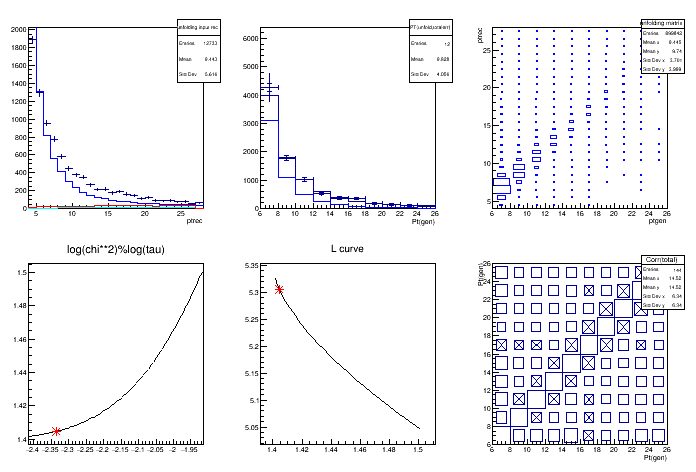

In [4]:
gROOT->GetListOfCanvases()->Draw()